# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install zipfile -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 1
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64
import warnings
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics
from dinglingling import wx_reminder

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    correct_column_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# global variables
SCKEY = 'SCU92138T03d57ff9d4b08ced24c2cceb440cd3bd5e843242680de'  # used for reminding when feature engineering or model training completes

In [4]:
# functions
def __dummy():
    pass

def _random_param_generator():
    scale_pos_weight = np.random.choice([20, 25,30,35,40,45])
    num_leaves = np.random.choice([8,16,32,64,128])
    subsample = min(1,np.random.uniform(0.8,1.01))
    colsample_bytree = min(1, np.random.uniform(0.3,1.01))
    min_data_in_leaf = int(np.random.uniform(10,100))
    l1 = np.random.uniform(0,2)
    l2 = np.random.uniform(0,2)
#     lr = np.random.choice([0.001,0.005,0.015])
    yield (scale_pos_weight, 
            num_leaves,
            subsample,
            colsample_bytree,
            min_data_in_leaf,
            l1,
            l2,)

@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def feature_engineering_wrapper(params):
        """
        wrapper for feature engineering func 
        for reminding when it completes
        """
        fe_df = feature_engineering(**params)
        
        return fe_df    

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

8.1M	../data/2017_fault_data.h5
67M	../data/chunk_data_for_test.h5
4.2G	../data/code.zip
4.2G	../data/data_2017_all.h5
4.7G	../data/data_2017_new_all.h5
2.3G	../data/data_2017_tag_flag.h5
2.5G	../data/data_2017_tag_flag_raw.h5
12G	../data/data_2017_to_2018_all.h5
20M	../data/data_201808_test.h5
41M	../data/data_201808_test_all.h5
46M	../data/data_201808_test_b.h5
24M	../data/data_201808_test_raw.h5
6.9G	../data/data_2018_all.h5
7.9G	../data/data_2018_new_all.h5
2.5G	../data/data_2018_semifinals.h5
9.1G	../data/data_2018_semifinals_all.h5
3.9G	../data/data_2018_tag_flag.h5
4.2G	../data/data_2018_tag_flag_raw.h5
36K	../data/disk_sample_fault_tag.csv
8.0K	../data/disk_sample_fault_tag_201808.csv
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G

In [6]:
# feature engineering
params = {
    'filename':'data_2018_semifinals_all.h5', # file we want to load for feature engineering
    'fe_save_filename':'fe_df_01_01_round_2_naive_cate_encoding.feather',  # naming the train fe by the start date of train not include 2017 data date
    'use_2017_fault_data':True,
    'clip_start_date': '2018-01-01', # start date of data for doing feature engineering(not include 2017 data) e.g. 2018-02-01 
    'clip_end_date': '2018-08-31',  # end date of data for doing feature engineering e.g. 2018-06-30
    'use_model_id': None,  # 1,2 and None
    'is_train':True,
    'num_processes': 20,
}

fe_df = feature_engineering_wrapper(params)

2020-04-02 14:46:42,244 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-02 14:46:42,260 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: True，数据集截断起始日期：2018-01-01, 数据集截断结束日期：2018-08-31
2020-04-02 14:46:42,261 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-02 14:46:42,262 - mlpipeline.feature_engineering - INFO - 加载数据集: ../data/data_2018_semifinals_all.h5
2020-04-02 14:50:41,457 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['smart_1_normalized', 'smart_3_normalized', 'smart_7_normalized', 'smart_9_normalized',
       'smart_187_normalized', 'smart_189_normalized', 'smart_191_normalized',
       'smart_193_normalized', 'smart_195_normalized', 'smart_4raw', 'smart_5raw', 'smart_9raw',
       'smart_12raw', 'smart_184raw', 'smart_188raw', 'smart_192raw', 'smart_194raw',
       'smart_197raw', 'smart_198raw', 'smart_199raw', 'dt', 'serial_number', 'model', 'tag',
       'flag'],
      dtype='object')
2020-04-02 14:50:41,4

  0%|          | 212/179619 [00:06<1:22:21, 36.31it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|          | 260/179619 [00:08<1:43:09, 28.98it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|          | 305/179619 [00:09<1:24:13, 35.48it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|          | 323/179619 [00:10<1:30:38, 32.97it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters 

2020-04-02 16:15:17,403 - utils.utils - INFO - smart_187_normalized - 0.0%
2020-04-02 16:15:17,485 - utils.utils - INFO - smart_184raw - 0.0%
2020-04-02 16:15:17,567 - utils.utils - INFO - smart_188raw - 0.0%
2020-04-02 16:15:17,645 - utils.utils - INFO - smart_1_normalized - 0.0%
2020-04-02 16:15:17,719 - utils.utils - INFO - smart_3_normalized - 0.0%
2020-04-02 16:15:17,792 - utils.utils - INFO - smart_7_normalized - 0.0%
2020-04-02 16:15:17,864 - utils.utils - INFO - smart_189_normalized - 0.0%
2020-04-02 16:15:17,940 - utils.utils - INFO - smart_191_normalized - 0.0%
2020-04-02 16:15:18,017 - utils.utils - INFO - smart_193_normalized - 0.0%
2020-04-02 16:15:18,090 - utils.utils - INFO - smart_195_normalized - 0.0%
2020-04-02 16:15:18,162 - utils.utils - INFO - smart_4raw - 0.0%
2020-04-02 16:15:18,234 - utils.utils - INFO - smart_5raw - 0.0%
2020-04-02 16:15:18,308 - utils.utils - INFO - smart_12raw - 0.0%
2020-04-02 16:15:18,382 - utils.utils - INFO - smart_192raw - 0.0%
2020-04-0

In [6]:
# drop_cols = ['err_weight',
#              'err_weight_max_7',
#              'err_weight_min_7',
#              'err_weight_std_7',
#              'err_weight_diff_for_last_period_7',
#              'degradation_err_weight_min_7',
#             'degradation_err_weight_max_7',
#             'degradation_err_weight_std_7',
#             'degradation_err_weight',
#             'degradation_err_weight_diff_for_last_period_7',
#             'seek_err_weight_diff_for_last_period_7',
#             'seek_err_weight',
#             'seek_err_weight_min_7',
#             'seek_err_weight_max_7',
#             'seek_err_weight_std_7',
#             'model_type']
# drop_cols = ['smart_241raw',
#             'smart_240raw',
#             'smart_242raw',
#               'smart_191_normalized_slope_for_last_duration_7'
#       ]
#      
drop_cols = []

In [7]:
# parameter tuning
@wx_reminder(SCKEY=SCKEY, remind_started=True)
def tune_params(param_search_times):
    ret = []
    for i in tqdm(range(param_search_times)):
                scale_pos_weight, num_leaves,subsample,colsample_bytree,min_data_in_leaf, l1, l2 = next(_random_param_generator())
                model_params = {
                    "objective": "binary",
                    "boosting": 'gbdt',  # gbdt, dart
                    "learning_rate": 0.001,
                    "scale_pos_weight":scale_pos_weight,
                #     "is_unbalance": True,
                    "num_leaves": num_leaves,
                #     "max_bin":255,
                #     'min_gain_to_split': 20,
                #     "max_depth":7,
                    "metric": ["auc"],
                    "subsample": subsample,
                    "colsample_bytree": colsample_bytree,
                    "num_threads": 12,
                    "lambda_l2": l2,
                    "lambda_l1": l1,
                    "random_state": 2019,
                    "min_data_in_leaf": min_data_in_leaf,
                    "num_boost_round": 1000,
                    "device": 'cpu',
                #     'boost_from_average':False
                }  

                params = {
                    'model_params': model_params,
                    'model_name': 'lgb',
                    'fe_filename': 'sample_by_month_0.4_fe_df_01_01_round_2_naive_cate_encoding.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
                    'is_eval': True,
                    'use_standard': False,  # whether using sklearn-standard
                    'use_log': False,
                    'drop_cols':drop_cols,
                    'random_state':1,
            #         'focal_loss_alpha':0.25,
            #         'focal_loss_gamma':2,
                    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
                    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
                    'eval_on_model_id': None, # 1,2,None
                    'train_on_model_id':None, # 1 ,2 , None
                    'save_feat_important': False,
                    'use_next_month_fault_data':True,
                    'next_month_start_date':'2018-06-01',
                    'next_month_end_date':'2018-06-30',
                    'use_2017_fault_data':True,
                    'valid_start_date':'2018-07-01', 
                    'valid_end_date': '2018-07-31',
                }

                model, eval_df,f1_score = train(**params)
                ret += [(model_params, f1_score)]
    ret.sort(key=lambda x: x[1], reverse=True)
    best_param = ret[0]
    print('最优参数:{}'.format(best_param))
    return ret

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's auc: 0.725536	valid_1's auc: 0.683149
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.730035	valid_1's auc: 0.69473
[3]	training's auc: 0.743854	valid_1's auc: 0.725652
[4]	training's auc: 0.743911	valid_1's auc: 0.725605
[5]	training's auc: 0.750065	valid_1's auc: 0.732292
[6]	training's auc: 0.750098	valid_1's auc: 0.732302
[7]	training's auc: 0.754096	valid_1's auc: 0.735419
[8]	training's auc: 0.754654	valid_1's auc: 0.736318
[9]	training's auc: 0.757434	valid_1's auc: 0.73842
[10]	training's auc: 0.759957	valid_1's auc: 0.736902
[11]	training's auc: 0.760298	valid_1's auc: 0.735489
[12]	training's auc: 0.763184	valid_1's auc: 0.734081
[13]	training's auc: 0.765248	valid_1's auc: 0.734374
[14]	training's auc: 0.765035	valid_1's auc: 0.734156
[15]	training's auc: 0.767547	valid_1's auc: 0.73009
[16]	training's auc: 0.768182	valid_1's auc: 0.733797
[17]	training's auc: 0.768985	valid_1's auc: 0.734953
[18]	training's auc: 0.770329	va

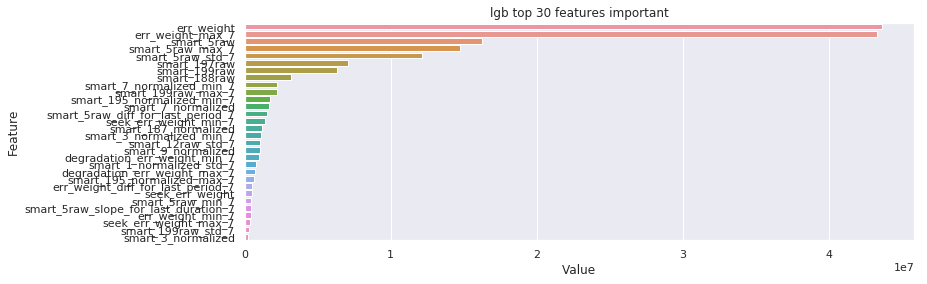

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
  5%|▌         | 1/20 [04:19<1:22:04, 259.20s/it]

[1]	training's auc: 0.785554	valid_1's auc: 0.689696
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.831322	valid_1's auc: 0.731291
[3]	training's auc: 0.846358	valid_1's auc: 0.740478
[4]	training's auc: 0.859235	valid_1's auc: 0.742631
[5]	training's auc: 0.868905	valid_1's auc: 0.748258
[6]	training's auc: 0.875573	valid_1's auc: 0.746995
[7]	training's auc: 0.879661	valid_1's auc: 0.74359
[8]	training's auc: 0.883671	valid_1's auc: 0.740419
[9]	training's auc: 0.890788	valid_1's auc: 0.739362
[10]	training's auc: 0.893976	valid_1's auc: 0.740023
[11]	training's auc: 0.897678	valid_1's auc: 0.744123
[12]	training's auc: 0.899734	valid_1's auc: 0.744798
[13]	training's auc: 0.90211	valid_1's auc: 0.743898
[14]	training's auc: 0.906101	valid_1's auc: 0.744594
[15]	training's auc: 0.908787	valid_1's auc: 0.745592
Early stopping, best iteration is:
[5]	training's auc: 0.868905	valid_1's auc: 0.748258


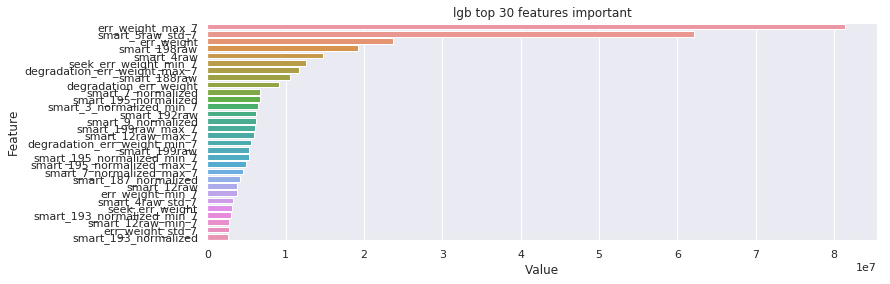

 10%|█         | 2/20 [08:46<1:18:26, 261.50s/it]

[1]	training's auc: 0.739118	valid_1's auc: 0.687097
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.760255	valid_1's auc: 0.721777
[3]	training's auc: 0.76597	valid_1's auc: 0.739643
[4]	training's auc: 0.766519	valid_1's auc: 0.736883
[5]	training's auc: 0.767827	valid_1's auc: 0.733861
[6]	training's auc: 0.769165	valid_1's auc: 0.736113
[7]	training's auc: 0.772209	valid_1's auc: 0.738014
[8]	training's auc: 0.776394	valid_1's auc: 0.736071
[9]	training's auc: 0.778945	valid_1's auc: 0.73487
[10]	training's auc: 0.780225	valid_1's auc: 0.739318
[11]	training's auc: 0.784006	valid_1's auc: 0.741763
[12]	training's auc: 0.787342	valid_1's auc: 0.739672
[13]	training's auc: 0.789143	valid_1's auc: 0.738883
[14]	training's auc: 0.789391	valid_1's auc: 0.738033
[15]	training's auc: 0.792093	valid_1's auc: 0.743418
[16]	training's auc: 0.79326	valid_1's auc: 0.74441
[17]	training's auc: 0.793852	valid_1's auc: 0.745019
[18]	training's auc: 0.798345	val

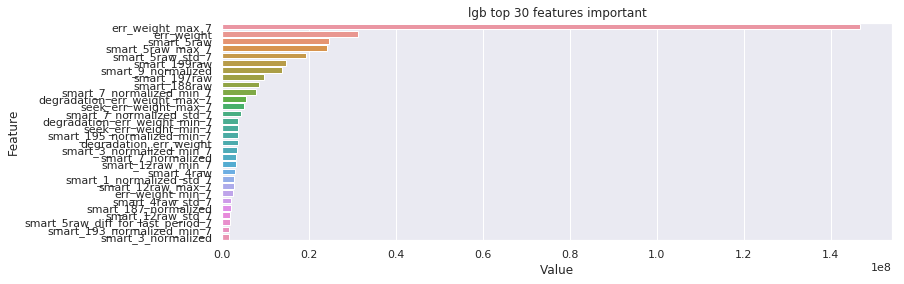

 15%|█▌        | 3/20 [13:14<1:14:40, 263.59s/it]

[1]	training's auc: 0.702338	valid_1's auc: 0.674986
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.702387	valid_1's auc: 0.675045
[3]	training's auc: 0.703416	valid_1's auc: 0.675203
[4]	training's auc: 0.726385	valid_1's auc: 0.696324
[5]	training's auc: 0.738753	valid_1's auc: 0.724011
[6]	training's auc: 0.746855	valid_1's auc: 0.734256
[7]	training's auc: 0.751327	valid_1's auc: 0.731999
[8]	training's auc: 0.752014	valid_1's auc: 0.733059
[9]	training's auc: 0.752244	valid_1's auc: 0.733402
[10]	training's auc: 0.751822	valid_1's auc: 0.733671
[11]	training's auc: 0.751633	valid_1's auc: 0.733541
[12]	training's auc: 0.751464	valid_1's auc: 0.733162
[13]	training's auc: 0.752722	valid_1's auc: 0.733621
[14]	training's auc: 0.754973	valid_1's auc: 0.732172
[15]	training's auc: 0.756056	valid_1's auc: 0.73184
[16]	training's auc: 0.755943	valid_1's auc: 0.731757
Early stopping, best iteration is:
[6]	training's auc: 0.746855	valid_1's auc: 0.734

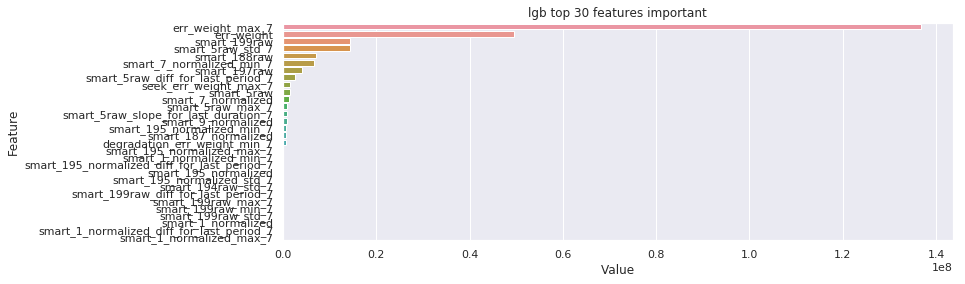

 20%|██        | 4/20 [17:18<1:08:43, 257.75s/it]

[1]	training's auc: 0.736922	valid_1's auc: 0.686254
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.758748	valid_1's auc: 0.718865
[3]	training's auc: 0.76098	valid_1's auc: 0.726981
[4]	training's auc: 0.765844	valid_1's auc: 0.72974
[5]	training's auc: 0.765972	valid_1's auc: 0.731092
[6]	training's auc: 0.768032	valid_1's auc: 0.731993
[7]	training's auc: 0.769964	valid_1's auc: 0.732467
[8]	training's auc: 0.771616	valid_1's auc: 0.731908
[9]	training's auc: 0.773994	valid_1's auc: 0.735197
[10]	training's auc: 0.776577	valid_1's auc: 0.732722
[11]	training's auc: 0.777285	valid_1's auc: 0.731954
[12]	training's auc: 0.777964	valid_1's auc: 0.731195
[13]	training's auc: 0.781746	valid_1's auc: 0.73149
[14]	training's auc: 0.782554	valid_1's auc: 0.732425
[15]	training's auc: 0.78252	valid_1's auc: 0.735931
[16]	training's auc: 0.783562	valid_1's auc: 0.736796
[17]	training's auc: 0.786615	valid_1's auc: 0.735545
[18]	training's auc: 0.790239	val

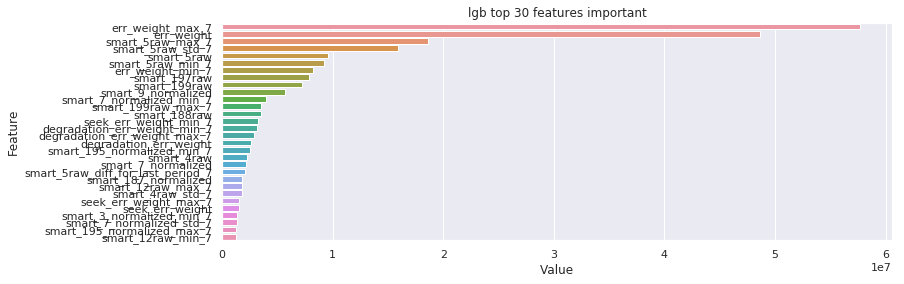

 25%|██▌       | 5/20 [21:40<1:04:42, 258.84s/it]

[1]	training's auc: 0.700093	valid_1's auc: 0.668114
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.755291	valid_1's auc: 0.719928
[3]	training's auc: 0.762735	valid_1's auc: 0.727374
[4]	training's auc: 0.764216	valid_1's auc: 0.73072
[5]	training's auc: 0.767271	valid_1's auc: 0.728559
[6]	training's auc: 0.769315	valid_1's auc: 0.729023
[7]	training's auc: 0.769648	valid_1's auc: 0.730277
[8]	training's auc: 0.775046	valid_1's auc: 0.731814
[9]	training's auc: 0.774973	valid_1's auc: 0.731281
[10]	training's auc: 0.775331	valid_1's auc: 0.73245
[11]	training's auc: 0.779519	valid_1's auc: 0.733156
[12]	training's auc: 0.779215	valid_1's auc: 0.732432
[13]	training's auc: 0.779605	valid_1's auc: 0.732486
[14]	training's auc: 0.779447	valid_1's auc: 0.732328
[15]	training's auc: 0.780864	valid_1's auc: 0.731956
[16]	training's auc: 0.781429	valid_1's auc: 0.730922
[17]	training's auc: 0.783681	valid_1's auc: 0.732747
[18]	training's auc: 0.786458	v

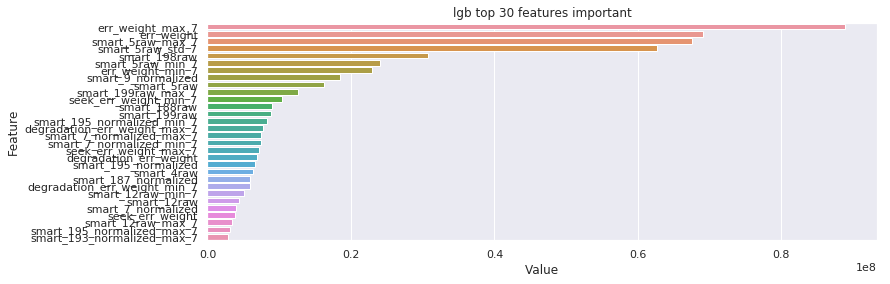

 30%|███       | 6/20 [26:40<1:03:18, 271.33s/it]

[1]	training's auc: 0.734922	valid_1's auc: 0.663744
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.795001	valid_1's auc: 0.720745
[3]	training's auc: 0.805299	valid_1's auc: 0.73283
[4]	training's auc: 0.809669	valid_1's auc: 0.735599
[5]	training's auc: 0.810908	valid_1's auc: 0.73922
[6]	training's auc: 0.817473	valid_1's auc: 0.746147
[7]	training's auc: 0.821516	valid_1's auc: 0.744031
[8]	training's auc: 0.825476	valid_1's auc: 0.740117
[9]	training's auc: 0.831685	valid_1's auc: 0.739978
[10]	training's auc: 0.834496	valid_1's auc: 0.739978
[11]	training's auc: 0.836145	valid_1's auc: 0.741124
[12]	training's auc: 0.838367	valid_1's auc: 0.7402
[13]	training's auc: 0.846124	valid_1's auc: 0.738348
[14]	training's auc: 0.846531	valid_1's auc: 0.740016
[15]	training's auc: 0.849576	valid_1's auc: 0.742676
[16]	training's auc: 0.850532	valid_1's auc: 0.741905
Early stopping, best iteration is:
[6]	training's auc: 0.817473	valid_1's auc: 0.746147

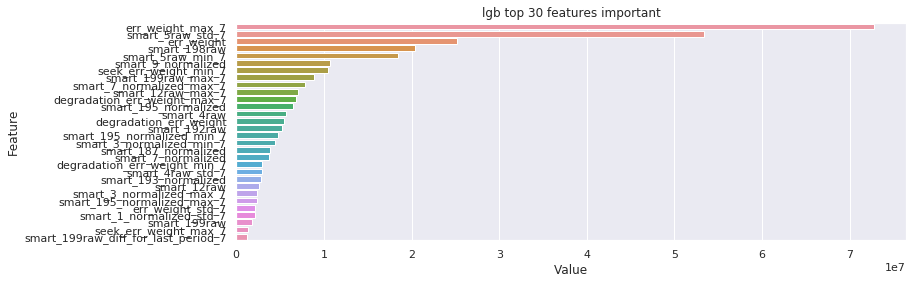

 35%|███▌      | 7/20 [30:51<57:27, 265.22s/it]  

[1]	training's auc: 0.729194	valid_1's auc: 0.695916
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.749041	valid_1's auc: 0.72526
[3]	training's auc: 0.757133	valid_1's auc: 0.733613
[4]	training's auc: 0.761163	valid_1's auc: 0.734018
[5]	training's auc: 0.763705	valid_1's auc: 0.734415
[6]	training's auc: 0.764996	valid_1's auc: 0.731725
[7]	training's auc: 0.767923	valid_1's auc: 0.730439
[8]	training's auc: 0.767525	valid_1's auc: 0.729756
[9]	training's auc: 0.769478	valid_1's auc: 0.730468
[10]	training's auc: 0.769184	valid_1's auc: 0.730196
[11]	training's auc: 0.772046	valid_1's auc: 0.729575
[12]	training's auc: 0.772042	valid_1's auc: 0.73025
[13]	training's auc: 0.773452	valid_1's auc: 0.730994
[14]	training's auc: 0.772637	valid_1's auc: 0.728402
[15]	training's auc: 0.772203	valid_1's auc: 0.728353
Early stopping, best iteration is:
[5]	training's auc: 0.763705	valid_1's auc: 0.734415


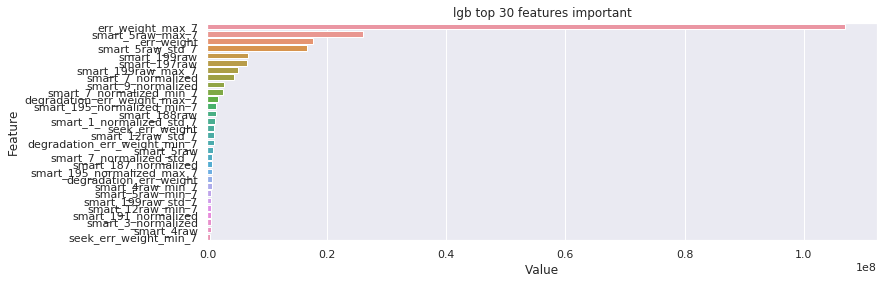

 40%|████      | 8/20 [34:54<51:44, 258.68s/it]

[1]	training's auc: 0.774711	valid_1's auc: 0.688281
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.795322	valid_1's auc: 0.717563
[3]	training's auc: 0.808068	valid_1's auc: 0.724509
[4]	training's auc: 0.810567	valid_1's auc: 0.729007
[5]	training's auc: 0.811889	valid_1's auc: 0.731811
[6]	training's auc: 0.818931	valid_1's auc: 0.73177
[7]	training's auc: 0.821763	valid_1's auc: 0.735013
[8]	training's auc: 0.823989	valid_1's auc: 0.732992
[9]	training's auc: 0.825848	valid_1's auc: 0.738319
[10]	training's auc: 0.828425	valid_1's auc: 0.737777
[11]	training's auc: 0.830894	valid_1's auc: 0.73939
[12]	training's auc: 0.833401	valid_1's auc: 0.737091
[13]	training's auc: 0.833137	valid_1's auc: 0.736776
[14]	training's auc: 0.835557	valid_1's auc: 0.740486
[15]	training's auc: 0.839295	valid_1's auc: 0.741602
[16]	training's auc: 0.840565	valid_1's auc: 0.74104
[17]	training's auc: 0.842343	valid_1's auc: 0.741771
[18]	training's auc: 0.845744	va

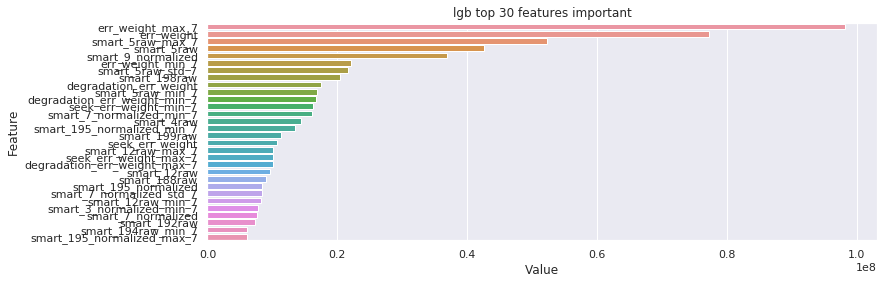

 45%|████▌     | 9/20 [40:57<53:09, 290.00s/it]

[1]	training's auc: 0.742425	valid_1's auc: 0.696476
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.763525	valid_1's auc: 0.722556
[3]	training's auc: 0.769218	valid_1's auc: 0.738711
[4]	training's auc: 0.774179	valid_1's auc: 0.736109
[5]	training's auc: 0.775903	valid_1's auc: 0.73493
[6]	training's auc: 0.780608	valid_1's auc: 0.734713
[7]	training's auc: 0.780888	valid_1's auc: 0.735365
[8]	training's auc: 0.788254	valid_1's auc: 0.738298
[9]	training's auc: 0.78831	valid_1's auc: 0.737962
[10]	training's auc: 0.79035	valid_1's auc: 0.737429
[11]	training's auc: 0.791559	valid_1's auc: 0.739936
[12]	training's auc: 0.79232	valid_1's auc: 0.73646
[13]	training's auc: 0.793023	valid_1's auc: 0.736279
[14]	training's auc: 0.792944	valid_1's auc: 0.736378
[15]	training's auc: 0.797463	valid_1's auc: 0.736141
[16]	training's auc: 0.797582	valid_1's auc: 0.736037
[17]	training's auc: 0.799757	valid_1's auc: 0.733605
[18]	training's auc: 0.802566	vali

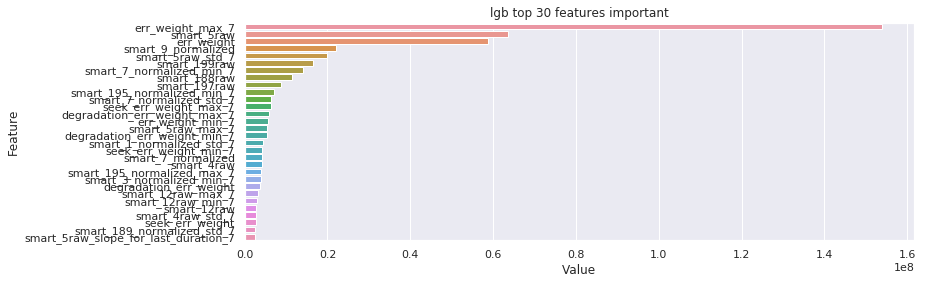

 50%|█████     | 10/20 [45:37<47:49, 286.95s/it]

[1]	training's auc: 0.772734	valid_1's auc: 0.706746
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.789386	valid_1's auc: 0.728011
[3]	training's auc: 0.79832	valid_1's auc: 0.736148
[4]	training's auc: 0.805849	valid_1's auc: 0.732695
[5]	training's auc: 0.805889	valid_1's auc: 0.736661
[6]	training's auc: 0.808614	valid_1's auc: 0.735156
[7]	training's auc: 0.810243	valid_1's auc: 0.735774
[8]	training's auc: 0.815338	valid_1's auc: 0.736332
[9]	training's auc: 0.818277	valid_1's auc: 0.733068
[10]	training's auc: 0.823775	valid_1's auc: 0.732359
[11]	training's auc: 0.824775	valid_1's auc: 0.733168
[12]	training's auc: 0.828967	valid_1's auc: 0.730802
[13]	training's auc: 0.833376	valid_1's auc: 0.729975
[14]	training's auc: 0.834472	valid_1's auc: 0.729798
[15]	training's auc: 0.838312	valid_1's auc: 0.731831
Early stopping, best iteration is:
[5]	training's auc: 0.805889	valid_1's auc: 0.736661


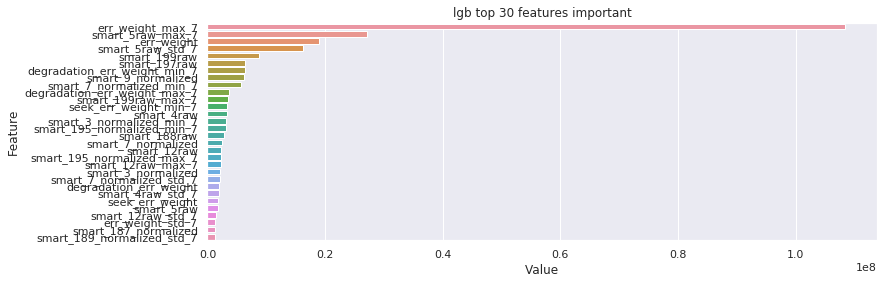

 55%|█████▌    | 11/20 [49:52<41:36, 277.38s/it]

[1]	training's auc: 0.783544	valid_1's auc: 0.699423
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.806287	valid_1's auc: 0.730546
[3]	training's auc: 0.821114	valid_1's auc: 0.731628
[4]	training's auc: 0.831873	valid_1's auc: 0.732692
[5]	training's auc: 0.83889	valid_1's auc: 0.735178
[6]	training's auc: 0.842686	valid_1's auc: 0.735903
[7]	training's auc: 0.848512	valid_1's auc: 0.738559
[8]	training's auc: 0.852754	valid_1's auc: 0.738325
[9]	training's auc: 0.860681	valid_1's auc: 0.737554
[10]	training's auc: 0.867194	valid_1's auc: 0.738467
[11]	training's auc: 0.872553	valid_1's auc: 0.737448
[12]	training's auc: 0.876171	valid_1's auc: 0.737776
[13]	training's auc: 0.877421	valid_1's auc: 0.736682
[14]	training's auc: 0.880523	valid_1's auc: 0.738726
[15]	training's auc: 0.884739	valid_1's auc: 0.73845
[16]	training's auc: 0.885966	valid_1's auc: 0.736834
[17]	training's auc: 0.887609	valid_1's auc: 0.737655
[18]	training's auc: 0.889398	v

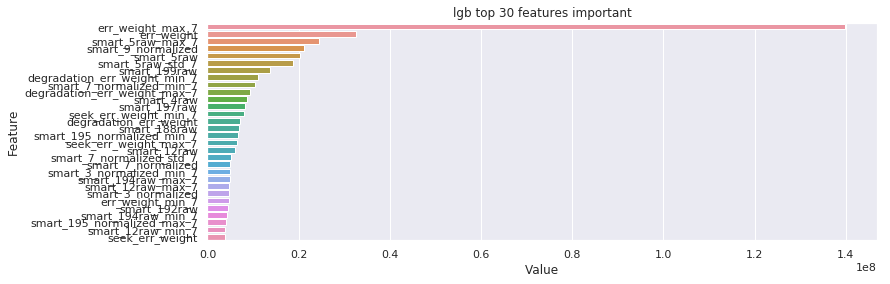

 60%|██████    | 12/20 [54:32<37:03, 277.91s/it]

[1]	training's auc: 0.772921	valid_1's auc: 0.71339
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.787229	valid_1's auc: 0.733777
[3]	training's auc: 0.798456	valid_1's auc: 0.737375
[4]	training's auc: 0.806246	valid_1's auc: 0.741359
[5]	training's auc: 0.810078	valid_1's auc: 0.741539
[6]	training's auc: 0.8193	valid_1's auc: 0.741348
[7]	training's auc: 0.822501	valid_1's auc: 0.746969
[8]	training's auc: 0.825258	valid_1's auc: 0.744113
[9]	training's auc: 0.829994	valid_1's auc: 0.743502
[10]	training's auc: 0.834214	valid_1's auc: 0.744191
[11]	training's auc: 0.83582	valid_1's auc: 0.741432
[12]	training's auc: 0.839032	valid_1's auc: 0.739454
[13]	training's auc: 0.84006	valid_1's auc: 0.739823
[14]	training's auc: 0.840291	valid_1's auc: 0.739489
[15]	training's auc: 0.844866	valid_1's auc: 0.739179
[16]	training's auc: 0.845125	valid_1's auc: 0.738611
[17]	training's auc: 0.847849	valid_1's auc: 0.734827
Early stopping, best iteration is:

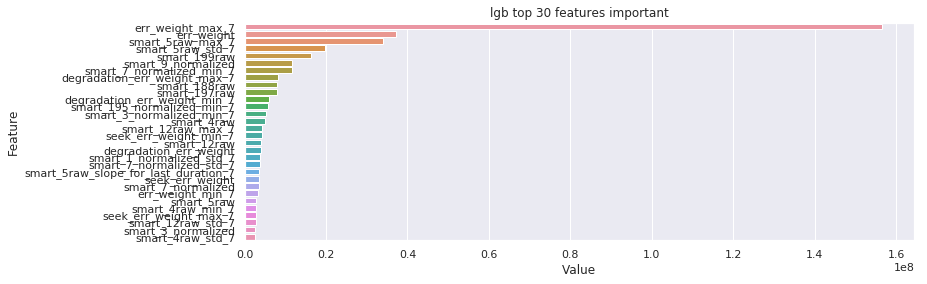

 65%|██████▌   | 13/20 [58:49<31:41, 271.65s/it]

[1]	training's auc: 0.702338	valid_1's auc: 0.674986
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.702386	valid_1's auc: 0.675045
[3]	training's auc: 0.706914	valid_1's auc: 0.674671
[4]	training's auc: 0.730993	valid_1's auc: 0.695872
[5]	training's auc: 0.745382	valid_1's auc: 0.721332
[6]	training's auc: 0.75186	valid_1's auc: 0.73091
[7]	training's auc: 0.753091	valid_1's auc: 0.732759
[8]	training's auc: 0.753022	valid_1's auc: 0.733501
[9]	training's auc: 0.752552	valid_1's auc: 0.733005
[10]	training's auc: 0.752461	valid_1's auc: 0.732959
[11]	training's auc: 0.755481	valid_1's auc: 0.731075
[12]	training's auc: 0.756777	valid_1's auc: 0.729484
[13]	training's auc: 0.756972	valid_1's auc: 0.729058
[14]	training's auc: 0.757837	valid_1's auc: 0.730945
[15]	training's auc: 0.758187	valid_1's auc: 0.733889
[16]	training's auc: 0.758783	valid_1's auc: 0.7308
[17]	training's auc: 0.759316	valid_1's auc: 0.73151
[18]	training's auc: 0.759741	vali

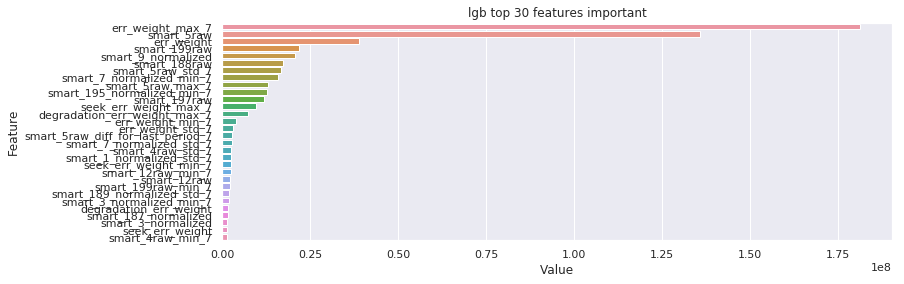

 70%|███████   | 14/20 [1:04:15<28:47, 287.94s/it]

[1]	training's auc: 0.730347	valid_1's auc: 0.696263
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.748363	valid_1's auc: 0.725193
[3]	training's auc: 0.753034	valid_1's auc: 0.721924
[4]	training's auc: 0.759019	valid_1's auc: 0.723678
[5]	training's auc: 0.762357	valid_1's auc: 0.724047
[6]	training's auc: 0.765782	valid_1's auc: 0.732027
[7]	training's auc: 0.76573	valid_1's auc: 0.733207
[8]	training's auc: 0.766197	valid_1's auc: 0.73496
[9]	training's auc: 0.766313	valid_1's auc: 0.73434
[10]	training's auc: 0.765791	valid_1's auc: 0.73095
[11]	training's auc: 0.765813	valid_1's auc: 0.730909
[12]	training's auc: 0.768192	valid_1's auc: 0.731814
[13]	training's auc: 0.768136	valid_1's auc: 0.730267
[14]	training's auc: 0.769034	valid_1's auc: 0.737379
[15]	training's auc: 0.77495	valid_1's auc: 0.736477
[16]	training's auc: 0.775323	valid_1's auc: 0.736947
[17]	training's auc: 0.77949	valid_1's auc: 0.736279
[18]	training's auc: 0.78029	valid_

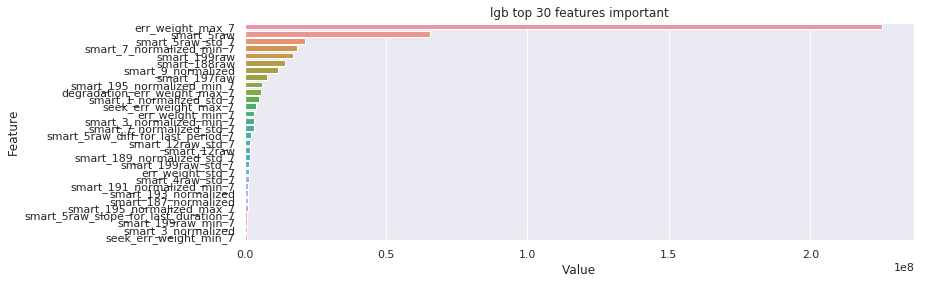

 75%|███████▌  | 15/20 [1:08:29<23:09, 277.98s/it]

[1]	training's auc: 0.727154	valid_1's auc: 0.690305
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.731283	valid_1's auc: 0.696427
[3]	training's auc: 0.746127	valid_1's auc: 0.729485
[4]	training's auc: 0.749012	valid_1's auc: 0.727367
[5]	training's auc: 0.755782	valid_1's auc: 0.733167
[6]	training's auc: 0.761884	valid_1's auc: 0.723444
[7]	training's auc: 0.765649	valid_1's auc: 0.722906
[8]	training's auc: 0.765818	valid_1's auc: 0.722262
[9]	training's auc: 0.765538	valid_1's auc: 0.722409
[10]	training's auc: 0.765392	valid_1's auc: 0.733775
[11]	training's auc: 0.768017	valid_1's auc: 0.73335
[12]	training's auc: 0.770527	valid_1's auc: 0.731964
[13]	training's auc: 0.771279	valid_1's auc: 0.731841
[14]	training's auc: 0.771347	valid_1's auc: 0.732287
[15]	training's auc: 0.771095	valid_1's auc: 0.73247
[16]	training's auc: 0.771455	valid_1's auc: 0.731479
[17]	training's auc: 0.771644	valid_1's auc: 0.731907
[18]	training's auc: 0.771993	v

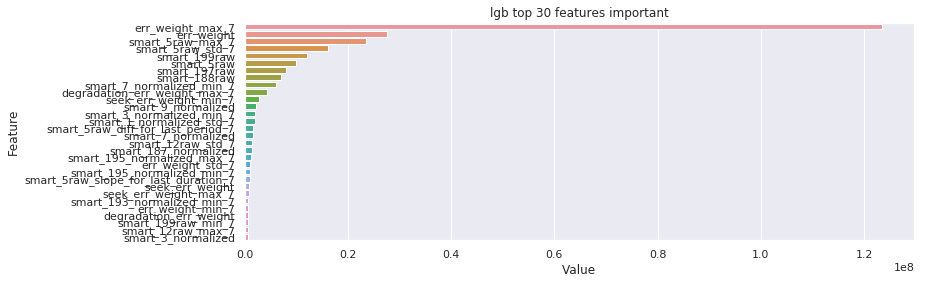

 80%|████████  | 16/20 [1:12:47<18:07, 271.99s/it]

[1]	training's auc: 0.77251	valid_1's auc: 0.722185
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.777335	valid_1's auc: 0.735084
[3]	training's auc: 0.780949	valid_1's auc: 0.734221
[4]	training's auc: 0.782812	valid_1's auc: 0.733158
[5]	training's auc: 0.790667	valid_1's auc: 0.732172
[6]	training's auc: 0.79476	valid_1's auc: 0.736257
[7]	training's auc: 0.795959	valid_1's auc: 0.73579
[8]	training's auc: 0.796341	valid_1's auc: 0.738044
[9]	training's auc: 0.801886	valid_1's auc: 0.735837
[10]	training's auc: 0.801231	valid_1's auc: 0.737517
[11]	training's auc: 0.80201	valid_1's auc: 0.735571
[12]	training's auc: 0.80469	valid_1's auc: 0.737033
[13]	training's auc: 0.810553	valid_1's auc: 0.742644
[14]	training's auc: 0.811676	valid_1's auc: 0.740996
[15]	training's auc: 0.812949	valid_1's auc: 0.743217
[16]	training's auc: 0.815546	valid_1's auc: 0.745027
[17]	training's auc: 0.815177	valid_1's auc: 0.74519
[18]	training's auc: 0.816455	valid

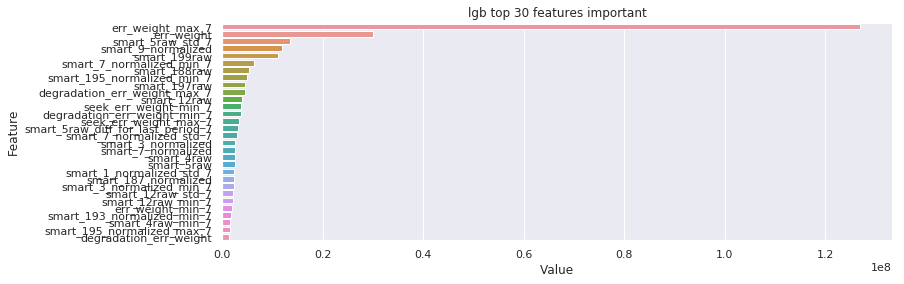

 85%|████████▌ | 17/20 [1:17:39<13:53, 277.99s/it]

[1]	training's auc: 0.797885	valid_1's auc: 0.693435
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.815589	valid_1's auc: 0.718537
[3]	training's auc: 0.829204	valid_1's auc: 0.718187
[4]	training's auc: 0.841408	valid_1's auc: 0.725217
[5]	training's auc: 0.850369	valid_1's auc: 0.729187
[6]	training's auc: 0.859307	valid_1's auc: 0.736262
[7]	training's auc: 0.864305	valid_1's auc: 0.734216
[8]	training's auc: 0.868361	valid_1's auc: 0.734172
[9]	training's auc: 0.870462	valid_1's auc: 0.733927
[10]	training's auc: 0.873833	valid_1's auc: 0.733027
[11]	training's auc: 0.878366	valid_1's auc: 0.733649
[12]	training's auc: 0.882932	valid_1's auc: 0.73157
[13]	training's auc: 0.887409	valid_1's auc: 0.732391
[14]	training's auc: 0.889208	valid_1's auc: 0.731753
[15]	training's auc: 0.895305	valid_1's auc: 0.73017
[16]	training's auc: 0.896484	valid_1's auc: 0.730101
Early stopping, best iteration is:
[6]	training's auc: 0.859307	valid_1's auc: 0.7362

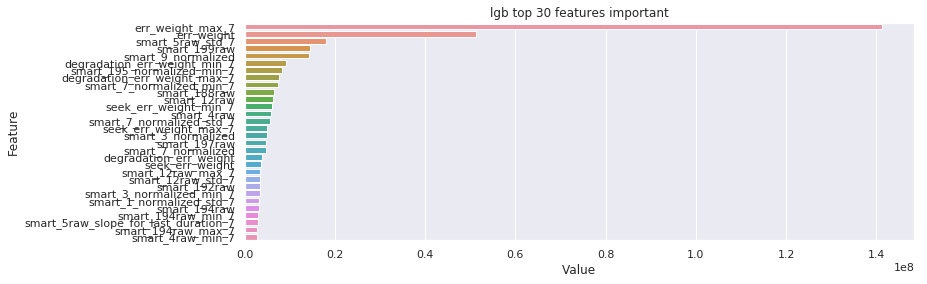

 90%|█████████ | 18/20 [1:22:16<09:14, 277.48s/it]

[1]	training's auc: 0.736594	valid_1's auc: 0.687116
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.762104	valid_1's auc: 0.72303
[3]	training's auc: 0.764776	valid_1's auc: 0.729556
[4]	training's auc: 0.766092	valid_1's auc: 0.731118
[5]	training's auc: 0.767377	valid_1's auc: 0.731916
[6]	training's auc: 0.768182	valid_1's auc: 0.734846
[7]	training's auc: 0.767928	valid_1's auc: 0.73215
[8]	training's auc: 0.772213	valid_1's auc: 0.734269
[9]	training's auc: 0.776079	valid_1's auc: 0.735111
[10]	training's auc: 0.777065	valid_1's auc: 0.736683
[11]	training's auc: 0.778571	valid_1's auc: 0.737652
[12]	training's auc: 0.779165	valid_1's auc: 0.737508
[13]	training's auc: 0.780292	valid_1's auc: 0.737524
[14]	training's auc: 0.780241	valid_1's auc: 0.737488
[15]	training's auc: 0.780877	valid_1's auc: 0.735489
[16]	training's auc: 0.783519	valid_1's auc: 0.735492
[17]	training's auc: 0.785562	valid_1's auc: 0.735027
[18]	training's auc: 0.790104	v

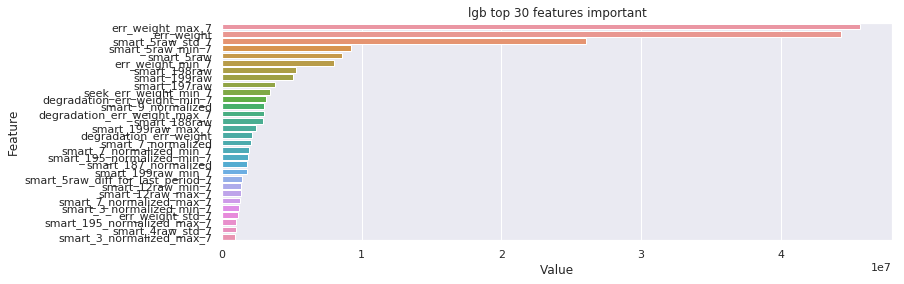

 95%|█████████▌| 19/20 [1:26:36<04:32, 272.32s/it]

[1]	training's auc: 0.72723	valid_1's auc: 0.690503
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.733681	valid_1's auc: 0.696345
[3]	training's auc: 0.733793	valid_1's auc: 0.696429
[4]	training's auc: 0.738245	valid_1's auc: 0.693114
[5]	training's auc: 0.754789	valid_1's auc: 0.72188
[6]	training's auc: 0.759025	valid_1's auc: 0.722871
[7]	training's auc: 0.75943	valid_1's auc: 0.722744
[8]	training's auc: 0.759866	valid_1's auc: 0.722354
[9]	training's auc: 0.762642	valid_1's auc: 0.727673
[10]	training's auc: 0.764132	valid_1's auc: 0.727051
[11]	training's auc: 0.766297	valid_1's auc: 0.727265
[12]	training's auc: 0.770531	valid_1's auc: 0.732027
[13]	training's auc: 0.770909	valid_1's auc: 0.731946
[14]	training's auc: 0.770675	valid_1's auc: 0.732079
[15]	training's auc: 0.770647	valid_1's auc: 0.732046
[16]	training's auc: 0.770723	valid_1's auc: 0.73191
[17]	training's auc: 0.770741	valid_1's auc: 0.731903
[18]	training's auc: 0.770691	val

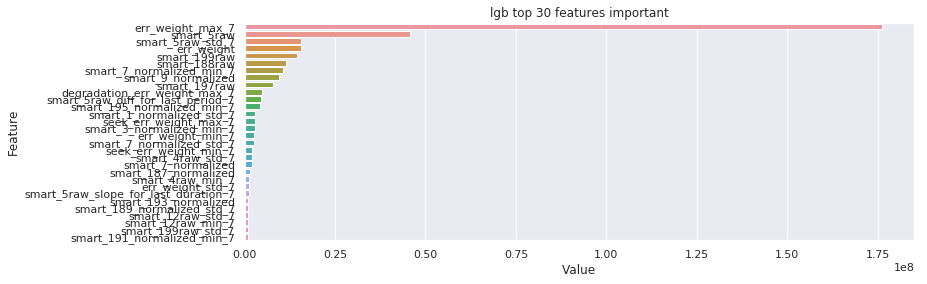

100%|██████████| 20/20 [1:31:10<00:00, 273.55s/it]


最优参数:({'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'scale_pos_weight': 40, 'num_leaves': 64, 'metric': ['auc'], 'subsample': 0.8924233447268193, 'colsample_bytree': 0.31964725891315077, 'num_threads': 12, 'lambda_l2': 0.5478556809575761, 'lambda_l1': 1.0280734580784423, 'random_state': 2019, 'min_data_in_leaf': 27, 'num_boost_round': 1000, 'device': 'cpu'}, 0.23473449179691291)


In [10]:
ret = tune_params(20)

100%|██████████| 3/3 [00:33<00:00, 11.26s/it]
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's auc: 0.700656	valid_1's auc: 0.693759
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.740415	valid_1's auc: 0.723015
[3]	training's auc: 0.748217	valid_1's auc: 0.735938
[4]	training's auc: 0.753321	valid_1's auc: 0.731408
[5]	training's auc: 0.753842	valid_1's auc: 0.732713
[6]	training's auc: 0.75963	valid_1's auc: 0.734102
[7]	training's auc: 0.759553	valid_1's auc: 0.733076
[8]	training's auc: 0.760612	valid_1's auc: 0.73284
[9]	training's auc: 0.764603	valid_1's auc: 0.731543
[10]	training's auc: 0.766867	valid_1's auc: 0.731709
[11]	training's auc: 0.768176	valid_1's auc: 0.732039
[12]	training's auc: 0.768004	valid_1's auc: 0.730069
[13]	training's auc: 0.76796	valid_1's auc: 0.729525
Early stopping, best iteration is:
[3]	training's auc: 0.748217	valid_1's auc: 0.735938


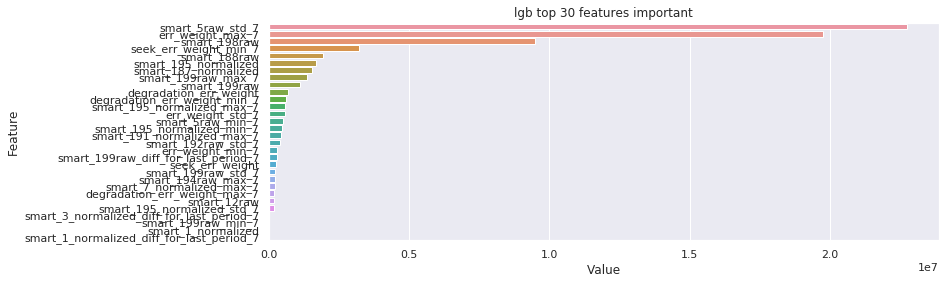

In [ ]:
# eval
model_params = {
            'objective': 'binary',
            'boosting': 'gbdt', 
            'learning_rate': 0.001, 
            'scale_pos_weight': 20, 
            'num_leaves': 16,
            'metric': ['auc'],
            'subsample': 0.8341500491577648, 
            'colsample_bytree': 0.3727020339353229, 
            'num_threads': 12, 
            'lambda_l2': 1.6310435018078826,
            'lambda_l1': 1.23238757828006462, 
            'random_state': 2019, 
            'min_data_in_leaf': 20,
            'num_boost_round': 1000, 
            'device': 'cpu'}

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'fe_df_01_01_round_2_with_cluster_label.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_standard': False,  # whether using sklearn-standard
    'use_log': False,
    'drop_cols':drop_cols,
    'use_sampling': True,
    'use_sampling_by_month_with_weight':False,
    'train_sample_ratio':0.35,
    'valid_sample_ratio':None,
    'save_sample_data':True,
    'random_state':2,
#         'focal_loss_alpha':0.25,
#         'focal_loss_gamma':2,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'eval_on_model_id': None, # 1,2,None
    'train_on_model_id':None, # 1 ,2 , None
    'save_feat_important': False,
    'use_2017_fault_data':True,
    'use_next_month_fault_data':True,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
}
model, eval_df,f1_score = train(**params) # 22913
# 22173226

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 7/7 [01:00<00:00,  8.69s/it]
../mlpipeline/train.py:299: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the futu

[1]	training's auc: 0.782459
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.813244
[3]	training's auc: 0.824505
[4]	training's auc: 0.827547
[5]	training's auc: 0.835035
[6]	training's auc: 0.838287
[7]	training's auc: 0.840232
[8]	training's auc: 0.843581
[9]	training's auc: 0.849294
[10]	training's auc: 0.850998
[11]	training's auc: 0.851921
[12]	training's auc: 0.860775
[13]	training's auc: 0.862889
[14]	training's auc: 0.867217
[15]	training's auc: 0.868892
[16]	training's auc: 0.872364
[17]	training's auc: 0.873423
[18]	training's auc: 0.876767
[19]	training's auc: 0.878232
[20]	training's auc: 0.88128
Did not meet early stopping. Best iteration is:
[20]	training's auc: 0.88128


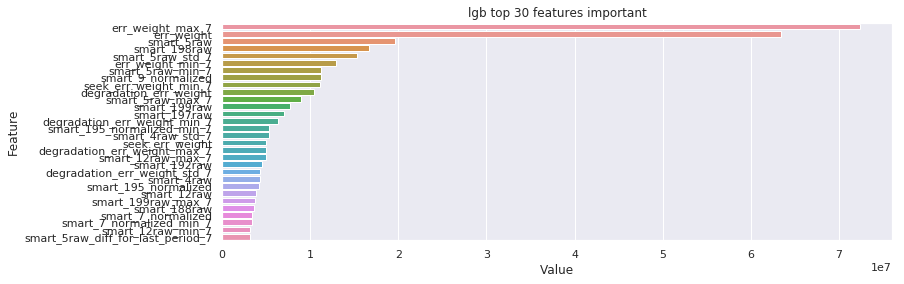

In [8]:
# train
model_params = {
            'objective': 'binary',
            'boosting': 'gbdt', 
            'learning_rate': 0.001, 
            'scale_pos_weight': 20, 
            'num_leaves': 116,
            'metric': ['auc'],
            'subsample': 0.8341500491577648, 
            'colsample_bytree': 0.4727020339353229, 
            'num_threads': 12, 
            'lambda_l2': 1.6310435018078826,
            'lambda_l1': 0.23238757828006462, 
            'random_state': 2019, 
            'min_data_in_leaf': 16,
            'num_boost_round': 20, 
            'device': 'cpu'}



params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'fe_df_01_01_round_2.feather',
#     'focal_loss_alpha':0.9,
#     'focal_loss_gamma':6,
    'use_sampling': True,
    'train_sample_ratio':0.4,
    'save_sample_data':False,
    'random_state':1,
    'drop_cols': drop_cols,
    'train_on_model_id':None,
    'is_eval': False,
    'use_standard': False,
    'use_log': False,
    'use_next_month_fault_data':False,
    'next_month_start_date':'2018-08-01',
    'next_month_end_date':'2018-08-30',
    'save_feat_important': False,
    'train_start_date': '2018-01-01',
    'train_end_date': '2018-07-31',
    'valid_start_date':'2018-09-01', 
}

model, scaler = train(**params)

In [ ]:
# predict 
params = {'model_name': 'lgb',
          'use_standard': False,
          'use_log': False,
          'scaler':'',
            }

submission_df = predict(**params)